# Generating new places in County Durham with neural networks

In the previous notebook we used bigrams to generate place names in County Durham as a basline model. Our goal now is to implement a neural network for the same task. We will see that performance is improved and we begin to generate place names that are more plausible.

We use a _multi-layer perceptron_ to generate the next character in a sequence of text in the spririt of [Bengio et al](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). We build the network from the ground up, closely following the [Andrej Karpathy video](https://www.youtube.com/watch?v=TCH_1BHY58I&t=2033s).

<font color='0789DF'>Table of contents<font><a class='anchor' id='top'></a>
- [Setting up](#settingup)
- [Building the dataset](#buildingdataset)
- [Network architecture](#architecture)
- [Lookup table](#lookuptable)
- [Hidden layer](#hiddenlayer)
- [Training the neural network](#training)
- [Evaluating the neural network](#eval)
- [Sampling from the neural network](#generating)

## Setting up <a class="anchor" id="settingup">

The following libraries are required for the neural networks we will build and for plotting.

In [47]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Let's import the dataset of place names in County Durham.

In [48]:
places = open('place_names_durham.txt', 'r').read().splitlines()

In [49]:
places[:5]

['addison', 'adelaide bank', 'aislaby', 'albany', 'albert hill']

We can check to see all the characters contained in `places`.

In [50]:
chars = sorted(list(set(''.join(places))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: ' ', 2: "'", 3: '-', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z', 0: '.'}


Our neural network will see each character through an integer label and we map this using the dictionary `stoi`. Similarly, the dictionary that maps in the other direction is `itos`. Recall that we introduce a fullstop to indicate the beginning or end of a place name.

In [51]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

## Building the dataset <a class="anchor" id="buildingdataset">

To train our model we first build up the requisite datasets that will be fed into our neural network.

__What is the basic idea of our neural network?__ The input to our neural network will be a sequence of characters encoded by integers. The number of characters will be given by the variable `block_size` that is sometimes referred to as the _context_. The output of our neural network is a vector of probabilities on the character set determining which character should come next. 
    
If the sequence of characters fed into the model was `d`, `u` and `r` then we would like it to assign a large probability that `h` is next as the model should recognise `Durham` as a place name.

In [52]:
block_size = 3

From the dataset `places` we can construct an input tensor `X` and the corresponding true output `Y` through the function `build_dataset`.

In [53]:
def build_dataset(places):
    
    X, Y = [], []
    
    for w in places:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

We split our data into three sets:
 - _Training set_: Data to train our model ~80%
 - _Validation set_: Data to tune hyperparameters and check model is not overfitting ~10%
 - _Test set_: Data to test model performance on ~10%
 
__Random shuffling is useful__. We randomly shuffle the data so that the model does not learn any patterns in how the data was stored. If we fed the data in alphabetically, the model would not see that many place names begin with a `W` and the test loss would be much larger than we expect.

In [54]:
import random
random.seed(42)
random.shuffle(places)
n1 = int(0.8*len(places))
n2 = int(0.9*len(places))

Xtr, Ytr = build_dataset(places[:n1])
Xdev, Ydev = build_dataset(places[n1:n2])
Xte, Yte = build_dataset(places[n2:])

Let's have a sanity check to see if the data is in the form we desired.

In [55]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([11433, 3]), torch.int64, torch.Size([11433]), torch.int64)

Each row in `Xtr` contains three (=`block_size`) integers that encodes characters. The entries in `Ytr` corresponds to the integer that encodes the next letter. This is visualised below.

In [56]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> e
..e --> g
.eg --> g
egg --> l
ggl --> e
gle --> s
les --> c
esc --> l
scl --> i
cli --> f
lif --> f
iff --> e
ffe --> .
... --> a
..a --> l
.al --> s
als --> t
lst --> o
sto --> n
ton -->  


## Network architecture <a class="anchor" id="architecture">
    
The input to our neural network is a sequence of characters encoded by integers and the output is a vector of probabilities. How do we go from input to output? Below is a diagram that sketches the idea.

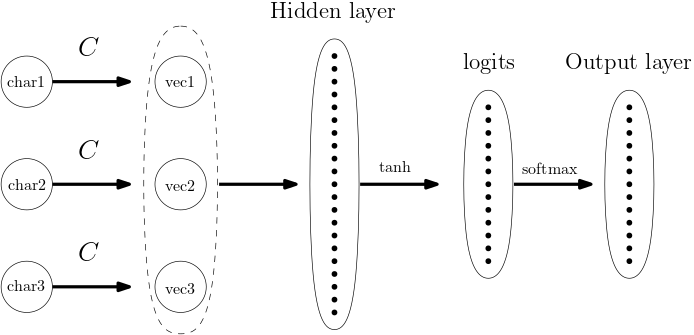

The input is a sequence of three characters `char1`, `char2` and `char3`. Each character is converted into a two-dimensional vector through a _lookup table_ `C`.

The three vectors are flattened into a single vector `emb` and passed into the hidden layer through the operation `emb @ W1 + b1` where `W1` is a matrix of weights and `b1` is the bias. Note that `emb` is referencing that the characters are _embedded_ in a two-dimensional space.

Output from the hidden layer is passed through a tanh activation function to obtain a vector `h`. Define `logits` to be the vector given by `h @ W2 + b2` where `W2` is a matrix of weights and `b2` is the bias. 


`logits` is then converted into probabilities through a [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

The goal of training the neural network is to find weights and biases that will find the best mapping to correctly predict the next character in the training set in such a way that will generalise well to unseen data.

We will go through each step in detail below.

## Lookup table <a class="anchor" id="lookuptable">

We embed each character in two-dimensions through a _lookup table_ `C`. We initialise `C` randomly according to unit normal random variables and `C` will be updated when training our neural network. Note that the choice of a two-dimensional embedding is a choice that we can make through the variable `n_embd`.

In [57]:
n_embd = 2

C = torch.randn((vocab_size, n_embd))
C[5]

tensor([-3.1818, -1.7203])

__Why do we introduce the lookup table?__ The lookup table can be viewed as an embedding of the characters in two-dimensions. This embedding allows the neural network to learn when characters share similar attributes while also treating them as distinct. Thus lookup tables allow neural networks to learn much more structure about place names than $n$-grams can.

We create an embedding of the training set `Xtr` in two-dimensions with the variable `emb`.

In [58]:
emb = C[Xtr]
emb.shape

torch.Size([11433, 3, 2])

## Hidden layer <a class="anchor" id="hiddenlayer">

The network is fed three characters that are converted to integers that are then embedded in two-dimenions by the lookup table `C`. Hence what we feed into the hidden layer will be a six-dimensional object.

The number of units in the hidden layer can be chosen and we fix it to be 100 through the variable `n_hidden`. The initial weights of the network are unit gaussian random variables.
    
__Why unit gaussian random variables?__ A random starting initialisation is useful to break symmetry to ensure the full capacity of the model is used during training. A gaussian distribution is symmetric with thin tails which will output reasonable values. 
    
__But why unit gaussian?__ A good question! Zero mean and variance one seems like an ad hoc choice. For now, it will suit our purposes. When improving our network we see how a clever choice of scaling will improve how the network initially learns! If you're keen to know more now then look into [Kaiming initialisation](https://paperswithcode.com/method/he-initialization).

In [59]:
n_hidden = 100

W1 = torch.randn((n_embd * block_size, n_hidden))
b1 = torch.randn(n_hidden)

We want to compute `emb @ W1 + b1` but the dimensions do not agree.

We need to concatenate the inputs so that we can have `11433x6` dimensions rather than `11433x3x2` dimensions for `emb`.

The following code is an easy way of doing this.

In [60]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([11433, 6])

An even better way is using `.view`! A major benefit of manipulating tensors with `.view` is that it does not require any additional memory. Find out more about PyTorch internals in [Edward Yang's blog post](http://blog.ezyang.com/2019/05/pytorch-internals/).

In [61]:
emb.view(-1, n_embd * block_size).shape

torch.Size([11433, 6])

Observe that `b1.shape = torch.Size([100])`. How does `emb.view(-1, 6) @ W1 + b1` make sense when the dimensions do not agree? PyTorch fixes this with _broadcasting_.

If a dimension in a tensor is either 1 or does not exist, then PyTorch will adopt the broadcasting rules that will fill in the dimensions needed for addition to make sense.

We pass through a tanh activation function with `torch.tanh`.

In [62]:
h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1)
h.shape

torch.Size([11433, 100])

The next layer takes `h` as input and maps to each character through the mapping `h @ W2 + b2` where `W2` and `b2` are initialised as unit normal random variables.

In [63]:
W2 = torch.randn((n_hidden, vocab_size))
b2 = torch.randn(vocab_size)

logits = h @ W2 + b2
logits.shape

torch.Size([11433, 30])

We exponentiate to avoid numerical underflow issues and then normalise to assign a probability to each character of occuring next after the input sequence.

In [64]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([11433, 30])

__From our input of three characters we now have a vector of probabilities corresponding to the next character!__ Exactly. We want our neural network to take advantage of its architecture to _learn_ how to tune its weights so that it will minimise its loss on the training set. Recall that the loss is the negative log-likelihood with respect to the _true_ next character. 

In [65]:
loss = -prob[torch.arange(11433), Ytr].log().mean()
loss

tensor(15.9730)

## Training the neural network <a class="anchor" id="training">

For clarity we reinitialise our parameters below and store them together as `parameters`.

In [66]:
n_embd = 2
n_hidden = 100

C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size))
b2 = torch.randn(vocab_size)

parameters = [C, W1, b1, W2, b2]
num_pars = sum(p.nelement() for p in parameters)
print(f'Total number of parameters: {num_pars}')

Total number of parameters: 3790


To implement backpropagation to train our network we need to store the values of the gradient with respect to the parameters in a computational graph. Hence we need to tell our network that we will be storing our gradient values.

In [67]:
for p in parameters:
    p.requires_grad = True

__Are there situations when we do not need to store the gradient?__ Calculating gradients can be computationally expensive. If we just wanted to evaluate the network then we set `p.requires_grad = False` for each parameter `p` and save having to store gradients.

In [68]:
lossi = []
lossvali = []
stepi = []

# regularisation parameter
lambda_value = 0.002

for i in range(20000):
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 15000 else 0.01
    for p in parameters:
        p.data += -lr * (p.grad + lambda_value * p.data)
        
    # track stats
    stepi.append(i)
    lossi.append(loss.item())
    
    # track validation loss
    with torch.no_grad():
        emb_valid = C[Xdev]
        h_valid = torch.tanh(emb_valid.view(-1, 6) @ W1 + b1)
        logits_valid = h_valid @ W2 + b2
        loss_valid = F.cross_entropy(logits_valid, Ydev)
        lossvali.append(loss_valid.item())
        
print(loss.item())

2.166888475418091


__What is the purpose of__ `lambda_value`__?__ When updating the parameters we implement a _weight penalisation_. In effect, we are reducing the capacity of the model in order to ward against overfitting. The variable `lambda_value` controls the strength of this regularisation. 

## Evaluating the neural network <a class="anchor" id="eval">
    
To better understand how our network is performing we will plot the training loss and validation loss over the training phase.

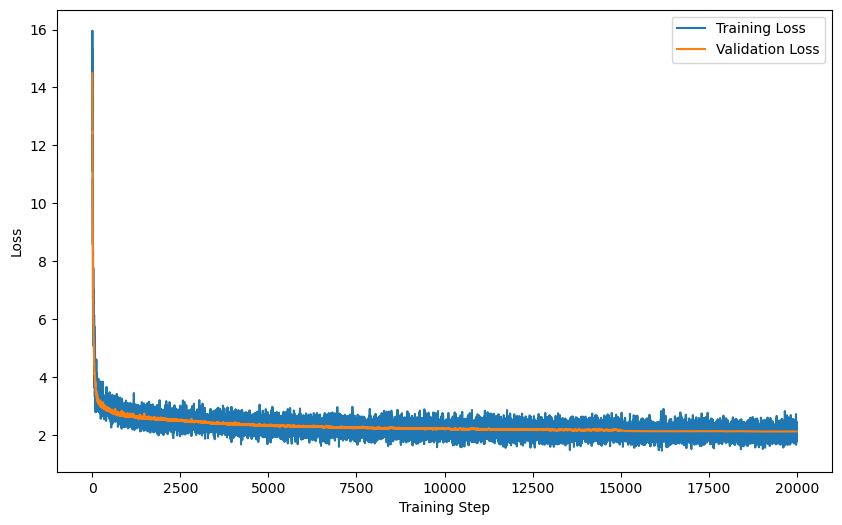

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(stepi, lossi, label="Training Loss")
plt.plot(stepi, lossvali, label="Validation Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

__Why is the initial loss so high?__ The initial loss is higher than it would be the model chose characters uniformly at random. The issue is the initial choice of weights and that the model is confidently wrong at the start and must spend time in the training loop moving away from the initial weights. 

__Why is the plot for the training loss so thick?__ There is randomness in the generation of batches and different batches will have different losses. One way to produce clearer plots is to take the mean over many training steps. We see this below.

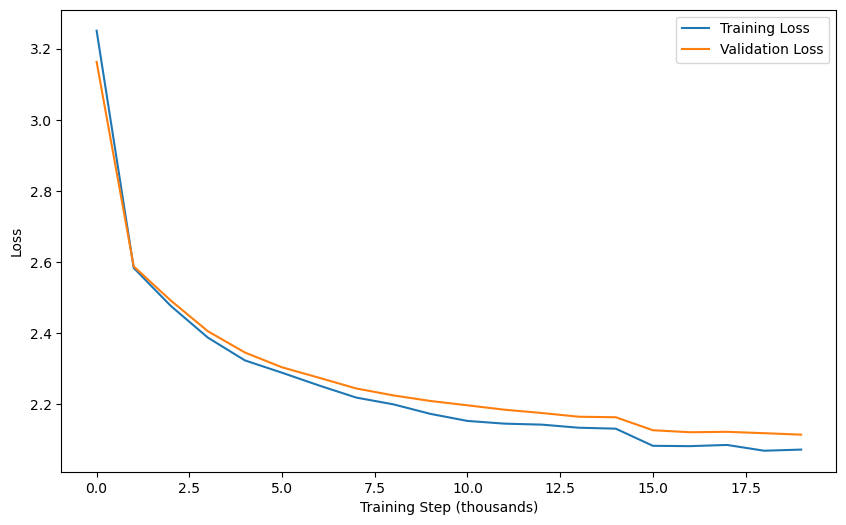

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1), label="Training Loss")
plt.plot(torch.tensor(lossvali).view(-1, 1000).mean(1), label="Validation Loss")
plt.xlabel("Training Step (thousands)")
plt.ylabel("Loss")
plt.legend()
plt.show()

That's clearer! 

Observe that the training loss is strictly less than the validation loss. This is to be expected as the model does not train on the validation set. The fact that both the training loss and validation are smaller than our benchmark means that our model is performing much better than the bigram model without overfitting.

As a final test we check the loss on the test set.

In [71]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss.item()

2.0828118324279785

All our losses are significantly lower than the baseline of `2.42` from the bigram model and thus we have an improved method to sample new place names in County Durham!

## Sampling from the neural network <a class="anchor" id="generating">
    
With our shiny new model we can sample new places names in County Durham. How well will we do?

In [74]:
g = torch.Generator().manual_seed(21448347)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    output_string = ''.join(itos[i] for i in out)
    capitalized_output = output_string.title()
    
    print(capitalized_output)

Naton Ticgeswowen.
Low Haleasastath.
Rem.
Linbiphame.
Geoxtaston Leverttige.
Med Anortwsle.
Ideycla.
Wullitdor Hdon Wore Wawestick.
Khsle 'Urgntr.
Mill Ton.
Eadortate.
Wedcaidfe Meaytfate.
Glow-Told Jouth Este Grteadh.
Sill.
Furk.
Tenamon.
Llzdindollankteeson.
Saghe.
Nokkmmile Vo'Newhon.
Keumnstonddingars.


Notably better than the bigram model! However, we are still far from believable place names.

__Why don't we increase__ `block_size` __or the number of neurons?__ While increasing the context length or the size of the hidden layer will increase the capacity of the network, it is not a _scalable_ solution. It turns out that a better solution will be to have a _deeper_ network that is appropriately regularized. In the next notebook we will improve upon our neural network by adopting a more complex architecture along with a number of ways to ensure the model can still train efficiently.